#### Torch CNN - CIFAR10

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from models import CNN

BATCH_SIZE = 128
DOWNLOAD = False  # True if no dataset on local disk

transform = transforms.Compose([
    # Convert to tensor
    transforms.ToTensor(), 
    # Normalize w/ mean and std
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) 
])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=transform,
                                            )

# Select 5000 samples from train_dataset
subset_indices = list(range(5000))
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)
test_subset = torch.utils.data.Subset(test_dataset, subset_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, n_step):
    import os
    import json

    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'n_step': n_step
    }
    with open(f'{save_path}/SGD_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)
    

In [ ]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [8]:
from optim.sgd_sngl import OneStepSGD
from optim.sgd_mult import MultiStepSGD

def modeling(n_step=2, n_epochs=15, lr=0.01, momentum=0):
    model = CNN(n_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    if n_step == 1:
        optimizer = OneStepSGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = MultiStepSGD(model.parameters(), lr=lr, momentum=momentum, n_step=n_step)

    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs = [], [], [], [], [], []

    for epoch in range(n_epochs):
        model.train() 
        total_train, _train_err, _train_acc, running_loss = 0, 0, 0, 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train

        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)

        save_path = f'./metrics/'
        # save_performance(save_path,
        #                  train_losses, test_losses, train_errs, 
        #                  test_errs, train_accs, test_accs, n_step,
        #                  )

        if epoch % 20 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%')
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs

E [1/15]. train_loss_acc: 2.3004, 11.62%, test_acc: 13.32%
E [6/15]. train_loss_acc: 2.2509, 21.96%, test_acc: 21.90%
E [11/15]. train_loss_acc: 2.0249, 26.94%, test_acc: 27.82%


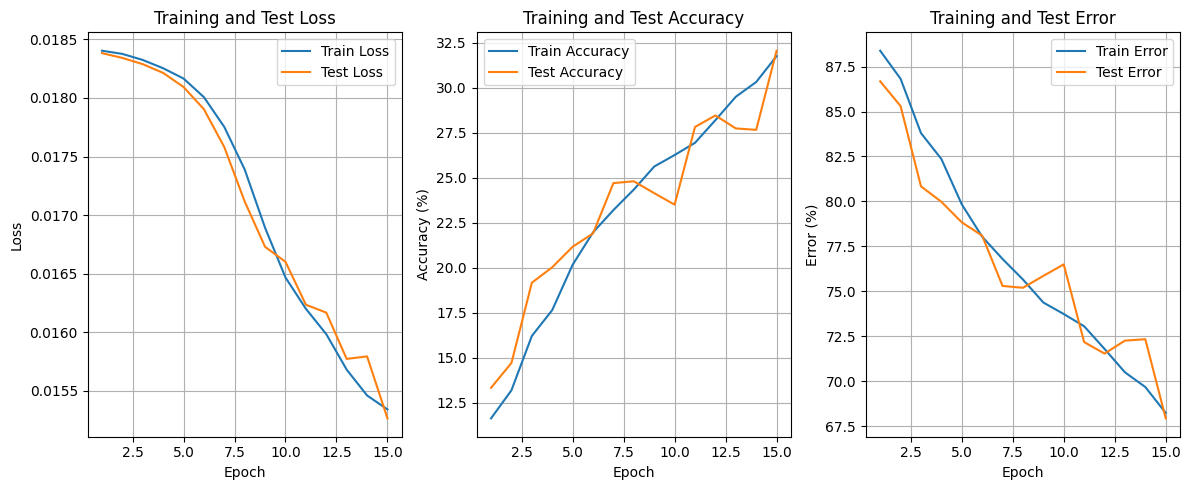

In [7]:
from plot import metrics_plot
n_epochs = 15
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs = modeling(n_step=1, n_epochs=n_epochs, lr=0.01, momentum=0)
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

E [1/100]. train_loss_acc: 2.3004, 12.60%, test_acc: 12.30%
E [21/100]. train_loss_acc: 1.8145, 34.70%, test_acc: 34.70%
E [41/100]. train_loss_acc: 1.5381, 44.90%, test_acc: 37.26%
E [61/100]. train_loss_acc: 1.3618, 52.06%, test_acc: 39.70%
E [81/100]. train_loss_acc: 1.1828, 57.88%, test_acc: 51.04%


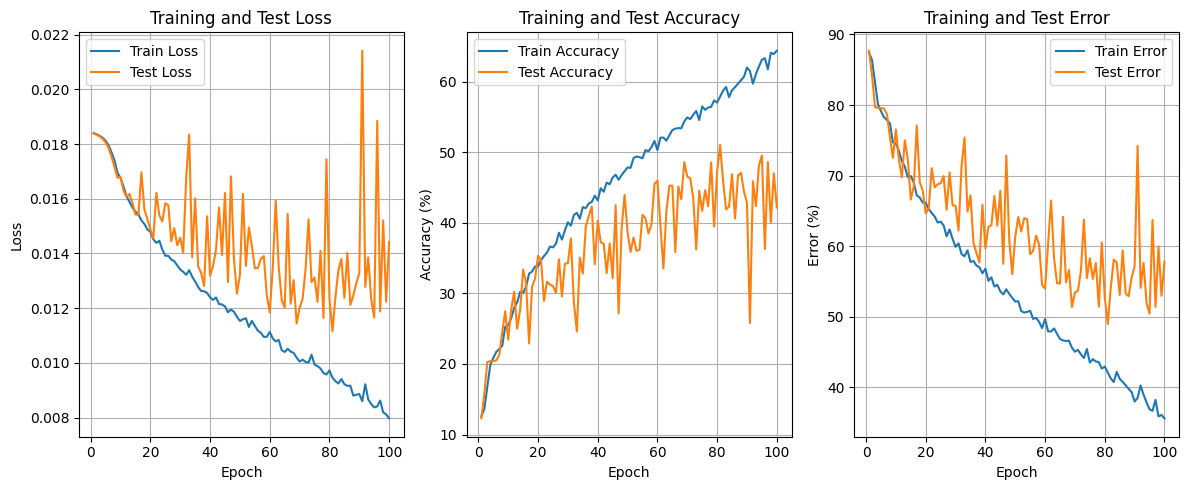

In [9]:
from plot import metrics_plot
n_epochs = 100
train_losses, test_losses, train_errs, test_errs, train_accs, test_accs = modeling(n_step=1, n_epochs=n_epochs, lr=0.01, momentum=0)
metrics_plot(n_epochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [ ]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=0.01)

### Backup

In [42]:
# load json file
import json
import os
def load_performance(n_step):
    file_path = f'metrics/multiSGD_{n_step}.json'
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            performance = json.load(f)
        return performance
    else:
        print(f"No performance data found for n_step={n_step}")
        return None

performance_data = {}
for n_step in range(1, 102, 10):
    performance = load_performance(n_step)
    test_errs = performance['test_errs'] if performance else []
    performance_data[n_step] = {
        'test_errs': test_errs
    }

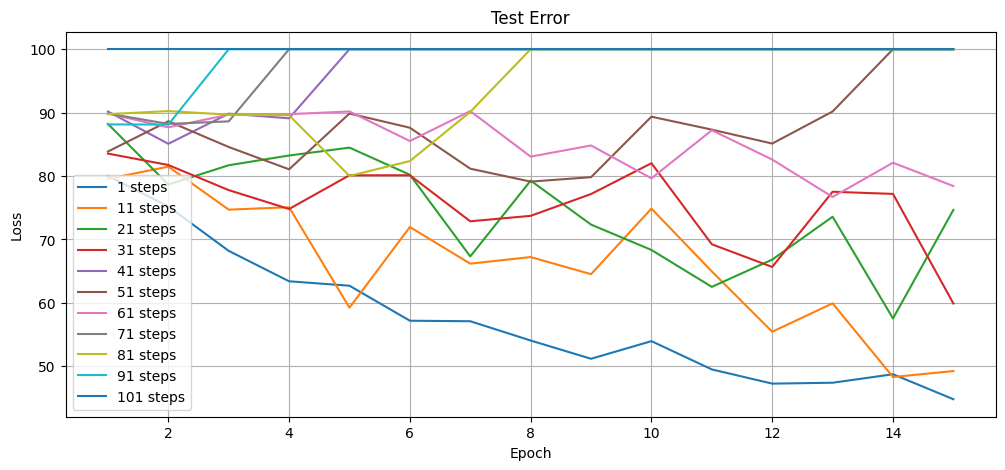

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
for n_step in range(1, 110):
    if n_step in performance_data:
        plt.plot(range(1, 16), performance_data[n_step]['test_errs'], label=f'{n_step} steps')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Error')
plt.legend()
plt.grid(True)
plt.show()